In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Energy reconstruction (MODEL)

**Recommended datasample(s):** model file, train and test data produced with ``protopipe-MODEL``

**Data level(s):** DL1b (telescope-wise image parameters) + DL2 (only shower geometry)

**Description:**

It should be used to test the performance of the trained model **before** use it to estimate the energy of DL2 events.

In fact, what happens in a *protopipe* analysis is that part of the TRAINING sample can be used for *testing* the models to get some preliminary diagnostics (i.e. before launching the much heavier DL2 production).

This notebook shows a camera-wise preliminary diagnostics.

Settings and setup of the plots are done using the same configuration file used for training the model.

**Requirements and steps to reproduce:**

- produce the model with ``protopipe-MODEL``

- Execute the notebook ``protopipe-BENCHMARK``,

``protopipe-BENCHMARK launch --config_file configs/benchmarks.yaml -n TRAINING/benchmarks_MODELS_energy``

To obtain the list of all available parameters add ``--help-notebook``.

**Developers**  

Please, if you have any contribution regarding this part, do it here and not in the relevant sections of the main code, which are now discontinued (they could be migrated back into ``protopipe.mva`` or in another place when more stable).

## Table of contents

* [Feature importance](#Feature-importance)
* [Feature distributions](#Feature-distributions)
* [Migration distribution](#Migration-distribution)
* [Energy resolution and bias](#Energy-resolution-and-bias)

## Imports
[back to top](#Table-of-contents)

In [2]:
import gzip
import glob
from pathlib import Path
import pickle
import joblib
import yaml

import numpy as np
import pandas as pd
import astropy.units as u
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams.update({'figure.max_open_warning': 0})

#import seaborn as sns
#sns.set_context("talk")

from protopipe.pipeline.utils import load_config

## Functions and classes
[back to top](#Table-of-contents)

In [3]:
def load_obj(name ):
    """Load object in binary"""
    with gzip.open(name, 'rb') as f:
        return pickle.load(f)

In [4]:
def plot_hist(ax, data, nbin, limit, norm=False, yerr=False, hist_kwargs={}, error_kw={}):
    """Utility function to plot histogram"""
    bin_edges = np.linspace(limit[0], limit[-1], nbin + 1, True)
    y, tmp = np.histogram(data, bins=bin_edges)
    weights = np.ones_like(y)
    if norm is True:
        weights = weights / float(np.sum(y))
    if yerr is True:
        yerr = np.sqrt(y) * weights
    else:
        yerr = np.zeros(len(y))

    centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    width = bin_edges[1:] - bin_edges[:-1]
    ax.bar(centers, y * weights, width=width, yerr=yerr, error_kw=error_kw, **hist_kwargs)

    return ax

In [5]:
def plot_distributions(suptitle,
                       feature_list,
                       data_list,
                       nbin=30,
                       hist_kwargs_list={},
                       error_kw_list={},
                       ncols=2):
    """Plot feature distributions for several data set. Returns list of axes."""
    n_feature = len(feature_list)
    nrows = int(n_feature / ncols) if n_feature % ncols == 0 else int((n_feature + 1) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
    plt.suptitle(suptitle)
    if nrows == 1 and ncols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, colname in enumerate(feature_list):
        ax = axes[i]

        for j, data in enumerate(data_list):
            if colname in ["hillas_intensity", "h_max", "impact_dist"]: # automatically log these quantities for clarity
                # Range for binning
                range_min = min([np.log10(data[colname]).min() for data in data_list])
                range_max = max([np.log10(data[colname]).max() for data in data_list])
                myrange = [range_min, range_max]
        
                ax = plot_hist(
                    ax=ax, data=np.log10(data[colname]), nbin=nbin, limit=myrange,
                    norm=True, yerr=True,
                    hist_kwargs=hist_kwargs_list[j],
                    error_kw=error_kw_list[j]
                )
                ax.set_xlabel(f"log10({colname})")
            else:
                range_min = min([data[colname].min() for data in data_list])
                range_max = max([data[colname].max() for data in data_list])
                myrange = [range_min, range_max]
                
                ax = plot_hist(
                    ax=ax, data=data[colname], nbin=nbin, limit=myrange,
                    norm=True, yerr=True,
                    hist_kwargs=hist_kwargs_list[j],
                    error_kw=error_kw_list[j]
                )

                ax.set_xlabel(colname)

        ax.set_ylabel('Arbitrary units')
        ax.legend(loc='upper left')
        ax.grid()
    plt.tight_layout()

    return fig, axes

In [6]:
def get_evt_subarray_model_output(data,
                                  weight_name="reco_energy_tel_weigth",
                                  keep_cols=['reco_energy'],
                                  model_output_name='reco_energy_tel',
                                  model_output_name_evt='reco_energy'):
    """
    Returns DataStore with keepcols + score/target columns of model at the
    level-subarray-event.
    
    Parameters
    ----------
    data: `~pandas.DataFrame`
        Data frame
    weight_name: `str`
        Variable name in data frame to weight events with
    keep_cols: `list`, optional
        List of variables to keep in resulting data frame
    model_output_name: `str`, optional
        Name of model output (image level)
    model_output_name: `str`, optional
        Name of averaged model output (event level)
    
    Returns
    --------
    data: `~pandas.DataFrame`
        Data frame
    """

    keep_cols += [model_output_name]
    keep_cols += [weight_name]
    new_data = data[keep_cols].copy(deep=True)

    new_data[model_output_name_evt] = np.zeros(len(new_data))
    new_data.set_index(["tel_id"], append=True, inplace=True)

    new_data[model_output_name_evt] = new_data.groupby(["obs_id", "event_id"]).apply(
        lambda g: np.average(g[model_output_name], weights=g[weight_name])
    )

    # Remove columns
    #new_data = new_data.drop(columns=[model_output_name])

    # Remove duplicates
    new_data = new_data[~new_data.index.duplicated(keep="first")]

    return new_data

In [7]:
class ModelDiagnostic(object):
    """
    Base class for model diagnostics.
    
    Parameters
    ----------
    model: `~sklearn.base.BaseEstimator`
        Best model
    feature_name_list: list
        List of the features used to buil the model
    target_name: str
        Name of the target (e.g. score, gamaness, energy, etc.)
    """
    def __init__(self, model, feature_name_list, target_name):
        self.model = model
        self.feature_name_list = feature_name_list
        self.target_name = target_name

    def plot_feature_importance(self, ax, **kwargs):
        """
        Plot importance of features
        Parameters
        ----------
        ax: `~matplotlib.axes.Axes`
            Axis
        """
        if ax is None:
            import matplotlib.pyplot as plt
            ax = plt.gca()

        importance = self.model.feature_importances_
        importance, feature_labels = \
            zip(*sorted(zip(importance, self.feature_name_list), reverse=True))

        bin_edges = np.arange(0, len(importance)+1)
        bin_width = bin_edges[1:] - bin_edges[:-1] - 0.1

        ax.bar(bin_edges[:-1], importance, width=bin_width, **kwargs)
        ax.set_xticks(np.arange(0, len(importance)))
        ax.set_xticklabels(feature_labels, rotation=75)

        return ax

    def plot_features(self,
                      suptitle,
                      data_list,
                      nbin=30,
                      hist_kwargs_list={},
                      error_kw_list={},
                      ncols=2):
        """
        Plot model features for different data set (e.g. training and test samples).
        Parameters
        ----------
        data_list: list
            List of data
        nbin: int
            Number of bin
        hist_kwargs_list: dict
            Dictionary with histogram options
        error_kw_list: dict
            Dictionary with error bar options
        ncols: int
            Number of columns
        """
        return plot_distributions(
            suptitle,
            self.feature_name_list,
            data_list,
            nbin,
            hist_kwargs_list,
            error_kw_list, ncols
        )

    def add_image_model_output(self):
        raise NotImplementedError("Please Implement this method")

In [8]:
class RegressorDiagnostic(ModelDiagnostic):
    """
    Class to plot several diagnostic plots for regression.
    
    Parameters
    ----------
    model: sklearn.base.BaseEstimator
        Scikit model
    feature_name_list: str
        List of features
    target_name: str
        Name of target (e.g. `mc_energy`)
    data_train: `~pandas.DataFrame`
        Data frame
    data_test: `~pandas.DataFrame`
        Data frame
    """
    def __init__(self, model,
                 feature_name_list,
                 target_name,
                 is_target_log,
                 data_train,
                 data_test,
                 output_name,
                 estimation_weight):
        super().__init__(model, feature_name_list, target_name)

        self.data_train = data_train
        self.data_test = data_test
        self.is_target_log = is_target_log

        self.target_estimation_name = self.target_name
        self.estimation_weight = estimation_weight

        self.output_name = output_name
        self.output_name_img = output_name + '_tel'
        self.output_weight_img = output_name + '_tel' + "_weight" 

        # Compute and add target estimation
        self.data_train = self.add_image_model_output(self.data_train)
        self.data_test = self.add_image_model_output(self.data_test)

    @staticmethod
    def plot_resolution_distribution(ax, y_true, y_reco, nbin=100, fit_range=[-3,3],
                                     fit_kwargs={}, hist_kwargs={}):
        """
        Compute bias and resolution with a gaussian fit
        and return a plot with the fit results and the migration distribution.
        """

        def gauss(x, ampl, mean, std):
            return ampl * np.exp(-0.5 * ((x - mean) / std) ** 2)

        if ax is None:
            ax = plt.gca()

        migration = (y_reco - y_true) / y_true
        bin_edges = np.linspace(fit_range[0], fit_range[-1], nbin + 1, True)
        y, tmp = np.histogram(migration, bins=bin_edges)
        x = (bin_edges[:-1] + bin_edges[1:]) / 2

        try:
            param, cov = curve_fit(gauss, x, y)
        except:
            param = [-1, -1, -1]
            cov = [[]]
            #print('Not enough stat ? (#evts={})'.format(len(y_true)))

        plot_hist(
            ax=ax, data=migration, nbin=nbin,
            yerr=False,
            norm=False,
            limit=fit_range,
            hist_kwargs=hist_kwargs
        )

        ax.plot(x, gauss(x, param[0], param[1], param[2]), **fit_kwargs)

        return ax, param, cov

    def add_image_model_output(self, data):
        
        features_values = data[features].to_numpy()
        
        if self.estimation_weight == "CTAMARS":
            # Get an array of trees
            predictions_trees = np.array([tree.predict(features_values) for tree in self.model.estimators_])
            v = np.mean(predictions_trees, axis=0)
            w = np.std(predictions_trees, axis=0)
            if self.is_target_log:
                data[self.output_name_img] = 10**v
                data[self.output_weight_img] = 10**w
            else:
                data[self.output_name_img] = v
                data[self.output_weight_img] = w
        else:
            data.eval(f'{self.output_weight_img} = {estimation_weight}', inplace=True)
            v = self.model.predict(features_values)
            if self.is_target_log:
                data[self.output_name_img] = 10**v
            else:
                data[self.output_name_img] = v

        return data

## Load models
[back to top](#Table-of-contents)

In [9]:
analyses_directory = None
analysis_name = None
model_configuration_filename = None # Name of the configuration file of the model
output_directory = Path.cwd() # default output directory for plots

In [10]:
# Parameters
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses"
analysis_name = "v0.5.0a1"
analysis_name_2 = ""
load_requirements = True
requirements_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/requirements/"
load_CTAMARS = True
input_data_CTAMARS = {
    "parent_directory": "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data",
    "TRAINING/DL1": "TRAINING/DL1",
    "TRAINING/DL2": "TRAINING/DL2",
    "DL2": "",
    "DL3": {
        "input_directory": "DL3",
        "input_file": "SubarrayLaPalma_4L15M_south_IFAE_50hours_20190630.root",
    },
    "label": "CTAMARS (2019)",
}
load_EventDisplay = True
input_data_EventDisplay = {
    "input_directory": "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2018-12-03/ROOT/North/CTA-Performance-North-20deg_20181203",
    "input_file": "CTA-Performance-North-20deg-S-50h_20181203.root",
    "label": "EventDisplay (2018)",
}
input_simtel_file = "/Users/michele/Applications/ctasoft/tests/data/simtel/gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz"
input_filenames = {
    "TRAINING_energy_gamma": "TRAINING_energy_tail_gamma_merged.h5",
    "TRAINING_classification_gamma": "TRAINING_classification_tail_gamma_merged.h5",
    "DL2_gamma": "DL2_tail_gamma_merged.h5",
    "DL2_proton": "DL2_energy_tail_gamma_merged.h5",
    "DL2_electron": "DL2_energy_tail_gamma_merged.h5",
    "DL3": "performance_protopipe_Prod3b_CTANorth_baseline_full_array_Zd20deg_180deg_Time50.00h.fits.gz",
}
model_configuration_filenames = {
    "energy": "RandomForestRegressor.yaml",
    "classification": "RandomForestClassifier.yaml",
}
input_filenames_ctapipe = {
    "DL1a_gamma": "events_protopipe_CTAMARS_calibration_1stPass.dl1.h5",
    "DL1a_gamma_2ndPass": "events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5",
}
output_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses/v0.5.0a1/benchmarks_results/MODELS"


In [11]:
# Check that the model configuration file has been defined
# either from the CLI of from the benchmarks configuration file (default)
if model_configuration_filename is None:
    try:
        model_configuration_filename = model_configuration_filenames["energy"]
    except KeyError:
        raise ValueError("The name of the configuration file is undefined.")

In [12]:
analysis_configuration_path = Path(analyses_directory) / analysis_name / Path("configs/analysis.yaml")
model_configuration_path = Path(analyses_directory) / analysis_name / "configs" / model_configuration_filename
input_directory = Path(analyses_directory) / analysis_name / Path("estimators/energy_regressor")

In [13]:
# Load configuration files
ana_cfg = load_config(analysis_configuration_path)
cfg = load_config(model_configuration_path)

# Get info from configs
estimation_weight = ana_cfg["EnergyRegressor"]["estimation_weight"]
model_type = "regressor"
method_name = cfg["Method"]["name"].split(".")[-1]
is_target_log = cfg["Method"]["log_10_target"]

In [14]:
cameras = [model.split('/')[-1].split('_')[1] for model in glob.glob(f"{input_directory}/{model_type}*.pkl.gz")]
data = {camera : dict.fromkeys(["model", "data_scikit", "data_train", "data_test"]) for camera in cameras} 

for camera in cameras:

    data[camera]["data_scikit"] = load_obj(
                glob.glob(f"{input_directory}/data_scikit_{model_type}_{method_name}_{camera}.pkl.gz")[0]
                )
    data[camera]["data_train"] = pd.read_pickle(
        glob.glob(f"{input_directory}/data_train_{model_type}_{method_name}_{camera}.pkl.gz")[0]
                )
    data[camera]["data_test"] = pd.read_pickle(
        glob.glob(f"{input_directory}/data_test_{model_type}_{method_name}_{camera}.pkl.gz")[0]
    )
    
    modelName = f"{model_type}_*_{camera}_{method_name}.pkl.gz"
    data[camera]["model"] = joblib.load(glob.glob(f"{input_directory}/{model_type}_{camera}_{method_name}.pkl.gz")[0])

## Settings and setup
[back to top](#Table-of-contents)

In [15]:
# Energy (both true and reconstructed)
nbins = cfg["Diagnostic"]["energy"]["nbins"]
energy_edges = np.logspace(
        np.log10(cfg["Diagnostic"]["energy"]["min"]),
        np.log10(cfg["Diagnostic"]["energy"]["max"]),
        nbins + 1,
        True,
    )

In [16]:
features_basic = cfg["FeatureList"]["Basic"]
features_derived = cfg["FeatureList"]["Derived"]
features = features_basic + list(features_derived)
features = sorted(features)

In [17]:
diagnostic = dict.fromkeys(cameras)
for camera in cameras:
    diagnostic[camera] = RegressorDiagnostic(
                    model=data[camera]["model"],
                    feature_name_list=features,
                    target_name="true_energy",
                    is_target_log=is_target_log,
                    data_train=data[camera]["data_train"],
                    data_test=data[camera]["data_test"],
                    output_name="reco_energy",
                    estimation_weight=estimation_weight
                )

In [18]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
plots_folder = Path(output_directory) / "plots"
plots_folder.mkdir(parents=True, exist_ok=True)

## Feature importance
[back to top](#Table-of-contents)

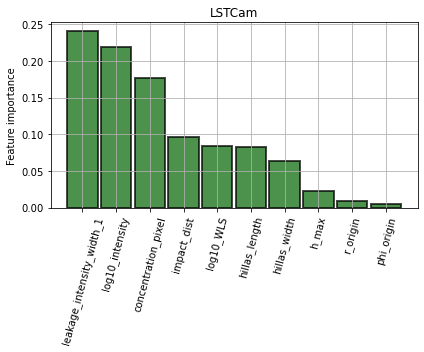

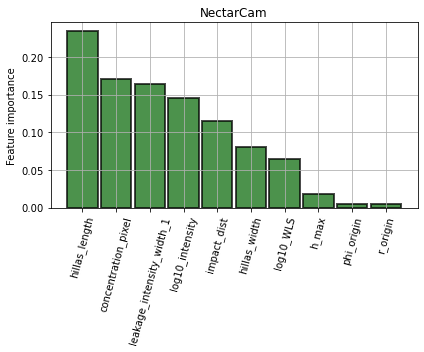

In [19]:
for camera in cameras:
    plt.figure(figsize=(6, 5))
    ax = plt.gca()
    ax = diagnostic[camera].plot_feature_importance(
        ax,
        **{"alpha": 0.7, "edgecolor": "black", "linewidth": 2, "color": "darkgreen"}
    )
    ax.set_ylabel("Feature importance")
    ax.grid()
    plt.title(camera)
    plt.tight_layout()
    plt.savefig(plots_folder / f"energy_model_feature_importance_{camera}_protopipe_{analysis_name}.png")

## Feature distributions
[back to top](#Table-of-contents)

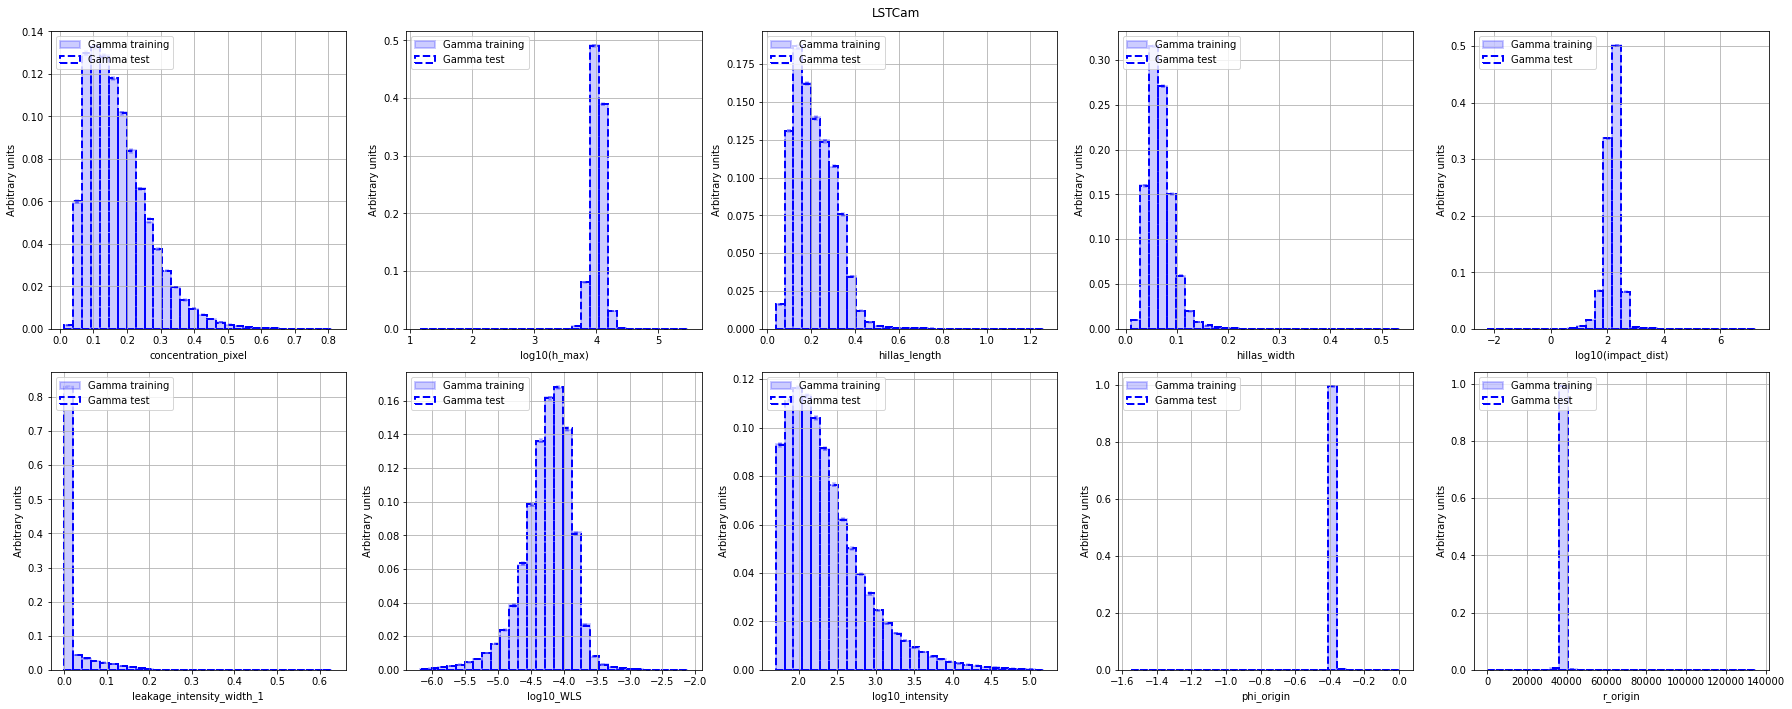

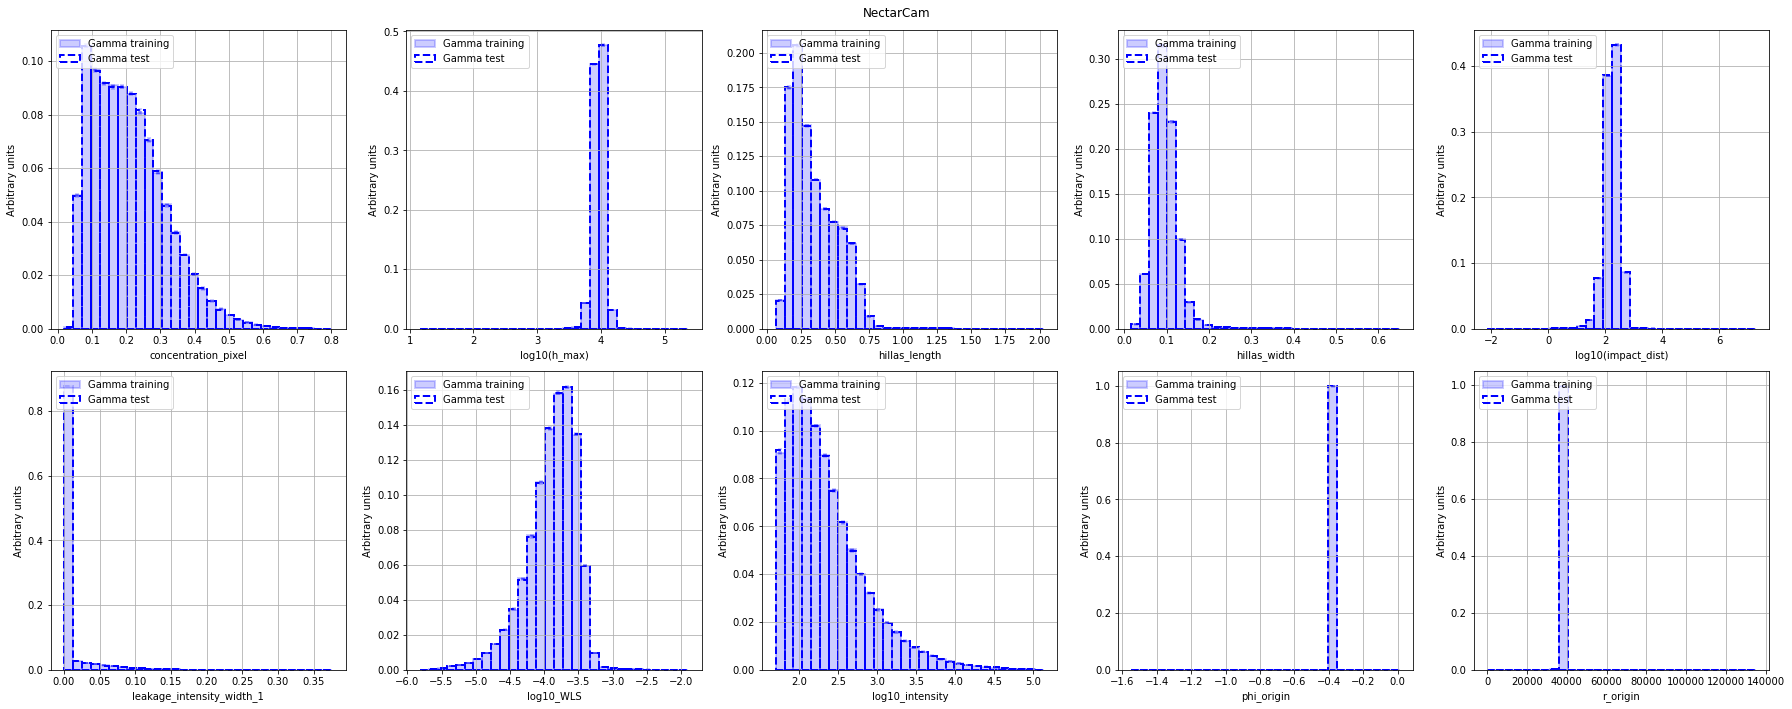

In [20]:
for camera in cameras:

    fig, axes = diagnostic[camera].plot_features(
        suptitle=camera,
        data_list=[data[camera]["data_train"], data[camera]["data_test"]],
        nbin=30,
        hist_kwargs_list=[
            {
                "edgecolor": "blue",
                "color": "blue",
                "label": "Gamma training",
                "alpha": 0.2,
                "fill": True,
                "ls": "-",
                "lw": 2,
            },
            {
                "edgecolor": "blue",
                "color": "blue",
                "label": "Gamma test",
                "alpha": 1,
                "fill": False,
                "ls": "--",
                "lw": 2,
            },
        ],
        error_kw_list=[
            dict(ecolor="blue", lw=2, capsize=2, capthick=2, alpha=0.2),
            dict(ecolor="blue", lw=2, capsize=2, capthick=2, alpha=0.2),
        ],
        ncols=5,
    )
    plt.savefig(plots_folder / f"energy_model_feature_distributions_{camera}_protopipe_{analysis_name}.png")

## Migration distribution
[back to top](#Table-of-contents)

**WARNING:** here we naively applying a gaussian fit for each slice in true energy, but it is not the best way especially for the lowest and highest bins (because of intrisinc tails in the ditributions and lower statistics respectively).

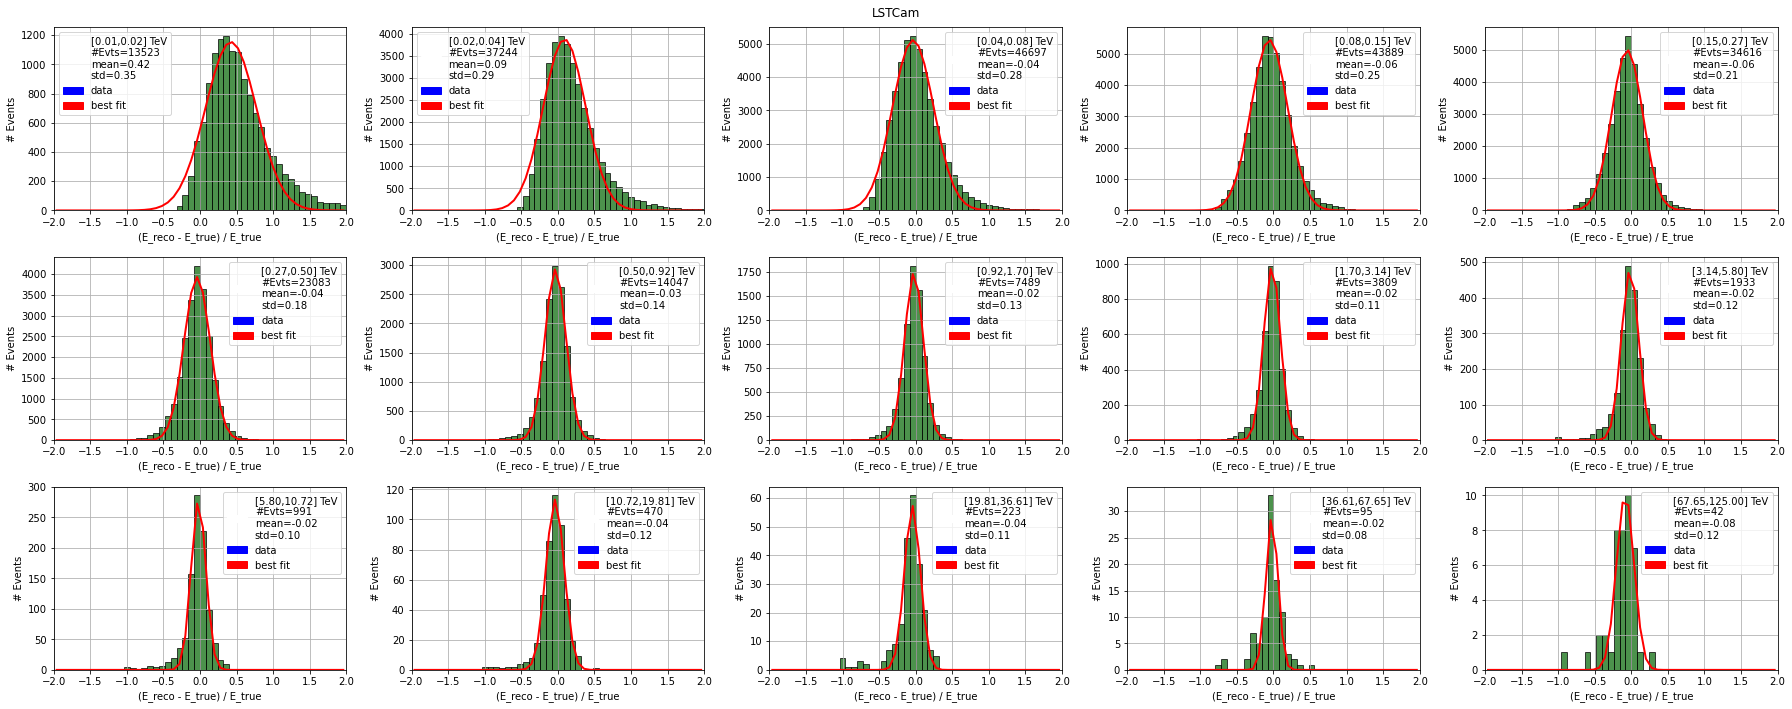

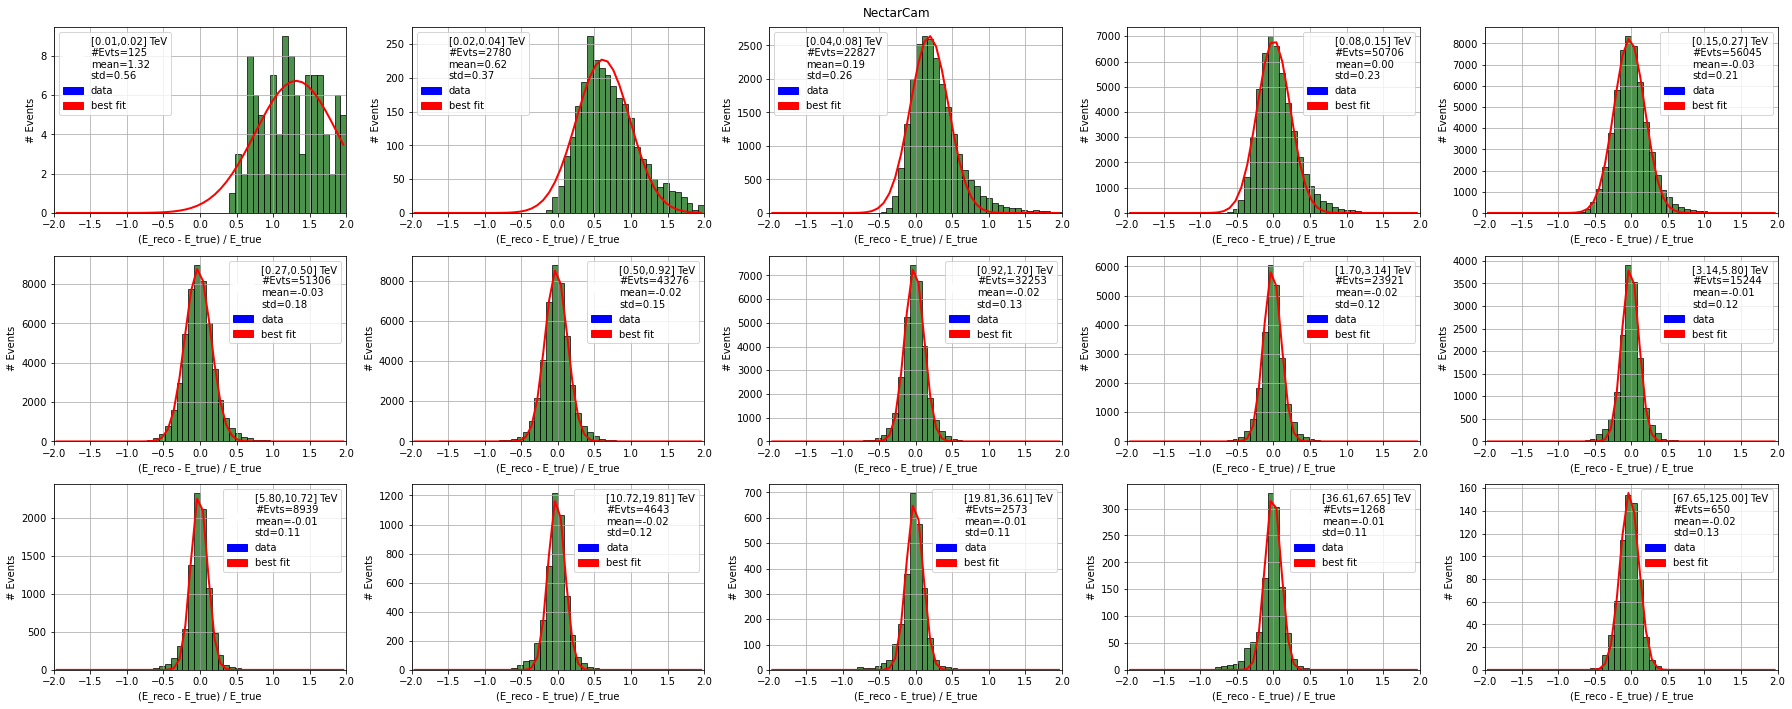

In [21]:
for camera in cameras:

    ncols = 5
    nrows = (
        int(nbins / ncols) if nbins % ncols == 0 else int((nbins + 1) / ncols)
    )
    if nrows == 0:
        nrows = 1
        ncols = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * 5, 10))
    plt.suptitle(camera)
    try:
        axes = axes.flatten()
    except:
        axes = [axes]

    bias = []
    resolution = []
    energy_centres = []

    for ibin in range(len(energy_edges) - 1):
        ax = axes[ibin]
        
        test_data = diagnostic[camera].data_test.query(
            "true_energy >= {} and true_energy < {}".format(
                energy_edges[ibin], energy_edges[ibin + 1]
            )
        )
        
        # print("Estimate energy for {} evts".format(len(test_data)))

        er = test_data["reco_energy_tel"]
        emc = test_data["true_energy"]

        opt_hist = {
            "edgecolor": "black",
            "color": "darkgreen",
            "label": "data",
            "alpha": 0.7,
            "fill": True,
        }
        opt_fit = {"c": "red", "lw": 2, "label": "Best fit"}
        ax, fit_param, cov = diagnostic[camera].plot_resolution_distribution(
            ax=ax,
            y_true=emc,
            y_reco=er,
            nbin=50,
            fit_range=[-2, 2],
            hist_kwargs=opt_hist,
            fit_kwargs=opt_fit,
        )
        if fit_param[2] < 0:  # negative value are allowed for the fit
            fit_param[2] *= -1

        label = "[{:.2f},{:.2f}] TeV\n#Evts={}\nmean={:.2f}\nstd={:.2f}".format(
            energy_edges[ibin],
            energy_edges[ibin + 1],
            len(er),
            fit_param[1],
            fit_param[2],
        )

        ax.set_ylabel("# Events")
        ax.set_xlabel("(E_reco - E_true) / E_true")
        ax.set_xlim([-2, 2])
        ax.grid()

        evt_patch = mpatches.Patch(color="white", label=label)
        data_patch = mpatches.Patch(color="blue", label="data")
        fit_patch = mpatches.Patch(color="red", label="best fit")
        ax.legend(loc="best", handles=[evt_patch, data_patch, fit_patch])
        plt.tight_layout()

        #print(
        #    " Fit results: ({:.3f},{:.3f} TeV)".format(
        #        energy_edges[ibin], energy_edges[ibin + 1]
        #    )
        #)

        #try:
        #    print(" - A    : {:.3f} +/- {:.3f}".format(fit_param[0], cov[0][0]))
        #    print(" - mean : {:.3f} +/- {:.3f}".format(fit_param[1], cov[1][1]))
        #    print(" - std  : {:.3f} +/- {:.3f}".format(fit_param[2], cov[2][2]))
        #except:
        #    print(" ==> Problem with fit, no covariance...".format())
        #    continue

        bias.append(fit_param[1])
        resolution.append(fit_param[2])
        energy_centres.append(
            (energy_edges[ibin] + energy_edges[ibin + 1]) / 2.0
        )

    plt.savefig(plots_folder / f"energy_model_migration_distributions_{camera}_protopipe_{analysis_name}.png")

## Energy resolution and bias
[back to top](#Table-of-contents)

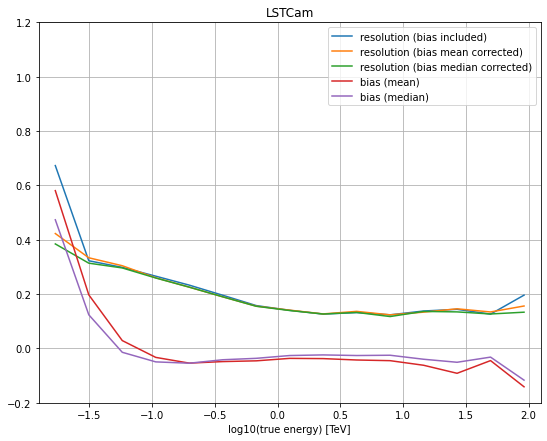

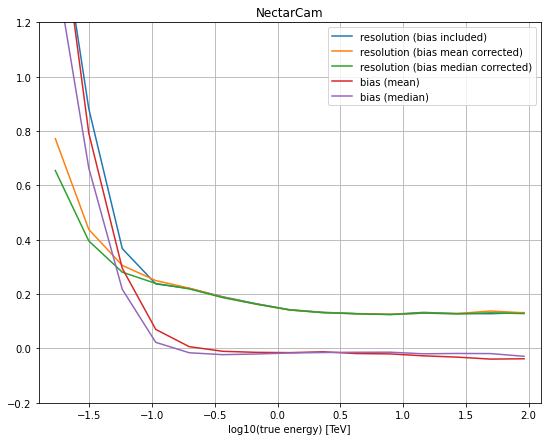

In [22]:
true_energy_bins_edges = np.linspace(
        np.log10(cfg["Diagnostic"]["energy"]["min"]),
        np.log10(cfg["Diagnostic"]["energy"]["max"]),
        nbins + 1,
        True,
    ) * u.TeV

true_energy_bins_centers = 0.5 * (true_energy_bins_edges[1:]+true_energy_bins_edges[:-1])

for camera in cameras:
    
    plt.figure(figsize=(9,7))

    reco_energy = diagnostic[camera].data_test[diagnostic[camera].output_name_img]
    true_energy = diagnostic[camera].data_test[diagnostic[camera].target_estimation_name]
    
    resolution = binned_statistic(np.log10(true_energy),
                              reco_energy/true_energy - 1,
                              statistic = lambda x: np.percentile(np.abs(x), 68),
                              bins=true_energy_bins_edges)

    corr_resolution_mean = binned_statistic(np.log10(true_energy),
                                  reco_energy/true_energy - 1,
                                  statistic = lambda x: np.percentile(np.abs(x-np.mean(x)), 68),
                                  bins=true_energy_bins_edges)
    
    corr_resolution_median = binned_statistic(np.log10(true_energy),
                                  reco_energy/true_energy - 1,
                                  statistic = lambda x: np.percentile(np.abs(x-np.median(x)), 68),
                                  bins=true_energy_bins_edges)
    
    bias_mean = binned_statistic(np.log10(true_energy), 
                        reco_energy/true_energy - 1, 
                        statistic="mean", 
                        bins=true_energy_bins_edges)
    
    bias_median = binned_statistic(np.log10(true_energy), 
                        reco_energy/true_energy - 1, 
                        statistic="median", 
                        bins=true_energy_bins_edges)
    
    plt.plot(true_energy_bins_centers, resolution[0], label="resolution (bias included)")
    plt.plot(true_energy_bins_centers, corr_resolution_mean[0], label="resolution (bias mean corrected)")
    plt.plot(true_energy_bins_centers, corr_resolution_median[0], label="resolution (bias median corrected)")
    plt.plot(true_energy_bins_centers, bias_mean[0], label="bias (mean)")
    plt.plot(true_energy_bins_centers, bias_median[0], label="bias (median)")
    plt.title(camera)
    plt.legend()
    plt.grid()
    plt.ylim(-0.2, 1.2)
    plt.xlim(np.log10(0.0125), np.log10(125))
    plt.xlabel('log10(true energy) [TeV]')

    plt.savefig(plots_folder / f"energy_model_resolution_bias_{camera}_protopipe_{analysis_name}.png")